In [1]:
import torch
import triton
import triton.language as tl
from copy import deepcopy
import transformers

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
transformers.__file__

'/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/transformers/__init__.py'

# Core

In [ ]:

@triton.jit
def _fused_silu_fwd(
        UP, GATE, Y,
        M, N,
        stride_m, stride_n,  #
        BLOCK_SIZE_N: tl.constexpr, #
):

    pid = tl.program_id(axis=0)
    offset = pid * stride_m
    cols = tl.arange(0, BLOCK_SIZE_N)
    mask = cols < N
    ptrs = offset + cols

    up = tl.load(UP+ptrs, mask=mask, other=0.)
    dtype = up.dtype
    up = up.to(tl.float32)
    gate = tl.load(GATE+ptrs, mask=mask, other=0.).to(tl.float32)
    act = gate * tl.sigmoid(gate)
    y = act * up
    tl.store(Y+ptrs, y.to(dtype), mask=mask)

@triton.jit
def _fused_silu_bwd_dupgate(UP, GATE, 
                               DY, DUP, DGATE,
                               stride_m, stride_n,
                               N, BLOCK_N: tl.constexpr
                               ):
    pid = tl.program_id(0)
    offset = pid * stride_m
    cols = tl.arange(0, BLOCK_N)
    ptrs = offset + cols
    mask = cols < N
    
    dy = tl.load(DY+ptrs, mask=mask, other=0.)
    dtype = dy.dtype
    gate = tl.load(GATE+ptrs, mask=mask, other=0.).to(tl.float32)
    up = tl.load(UP+ptrs, mask=mask, other=0.).to(tl.float32)

    act = gate * tl.sigmoid(gate)
    dup = act * dy
    dact = up * dy
    gate_neg_exp = tl.exp(-gate)
    tmp = 1 + gate_neg_exp
    fenzi =  tmp + gate * gate_neg_exp
    fenmu = tmp * tmp
    dgate = (fenzi / fenmu) * dact
    tl.store(DUP+ptrs, dup.to(dtype), mask=mask)
    tl.store(DGATE+ptrs, dgate.to(dtype), mask=mask)

class _FusedSiLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, up, gate):
        up = up.view(-1, up.shape[-1])
        M, N = up.shape
        y = torch.empty_like(gate)
        BLOCK_SIZE_N = triton.next_power_of_2(N)
        num_warps = 8
        num_stages = 1
        _fused_silu_fwd[(M,)](
            up, gate, y, 
            M, N,  #
            *up.stride(),  #
            BLOCK_SIZE_N,
            num_warps=num_warps, num_stages=num_stages, 
        )
        ctx.infos = (M, N, BLOCK_SIZE_N, *up.stride())
        ctx.save_for_backward(up, gate)
        ctx.num_warps = num_warps
        ctx.num_stages = num_stages
        return y
    
    @staticmethod
    def backward(ctx, dy):
        M, N, BLOCK_SIZE_N, stride_m, stride_n = ctx.infos
        up, gate = ctx.saved_tensors

        dup = torch.empty_like(gate)
        dgate = torch.empty_like(gate)

        _fused_silu_bwd_dupgate[(M,)](up, gate,
                                   dy, dup, dgate,
                                   stride_m, stride_n,
                                   N, BLOCK_SIZE_N, 
                                   num_warps=ctx.num_warps, num_stages=ctx.num_stages)

        return dup, dgate


def up_gate_silu(up, gate):
    return up * torch.nn.functional.silu(gate)

fused_up_gate_silu = _FusedSiLU.apply

# 精度测试

In [29]:
dim = 1024
bs = 64
dtype = torch.float32
up1 = torch.randn(bs, 2, dim).cuda().to(dtype)
gate1 = torch.randn(bs, 2, dim).cuda().to(dtype)
up1.requires_grad_(True)
gate1.requires_grad_(True)
up2 = deepcopy(up1)
gate2 = deepcopy(gate1)
dy = torch.ones_like(up1)


In [30]:
if up1.grad is not None:
    up1.grad.zero_()
    up2.grad.zero_()
    gate1.grad.zero_()
    gate2.grad.zero_()

y1 = up_gate_silu(up1, gate1)
y1.backward(dy)

y2 = fused_up_gate_silu(up2, gate2)
y2.backward(dy)

atol = 1e-3
print(torch.allclose(y1, y2, atol=atol))
print(torch.allclose(up1.grad, up2.grad, atol=atol))
print(torch.allclose(gate1.grad, gate2.grad, atol=atol))

True
True
True


# forward

bs: 32, seq_len: 1024


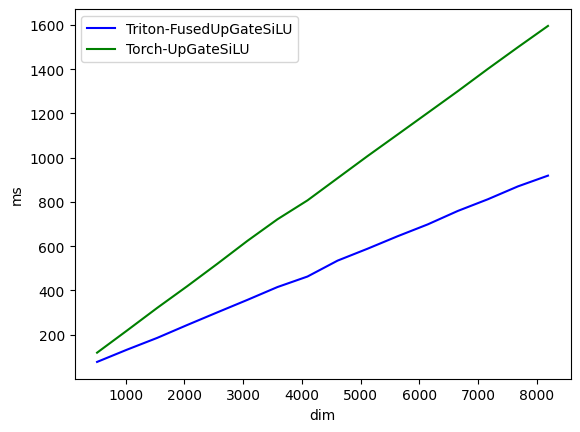

up gate silu forward:
       dim  Triton-FusedUpGateSiLU  Torch-UpGateSiLU
0    512.0               76.875538        118.608072
1   1024.0              132.503897        219.156817
2   1536.0              185.481846        321.039617
3   2048.0              243.831873        419.207811
4   2560.0              300.841957        520.327866
5   3072.0              357.223779        623.897970
6   3584.0              415.238798        721.533179
7   4096.0              462.842137        807.054222
8   4608.0              534.662426        907.352030
9   5120.0              588.641047       1007.470012
10  5632.0              645.057917       1104.842901
11  6144.0              698.478580       1202.625275
12  6656.0              759.247661       1300.526381
13  7168.0              812.073529       1401.204109
14  7680.0              870.249510       1499.284625
15  8192.0              918.847203       1595.489264


In [61]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedUpGateSiLU', 'Torch-UpGateSiLU'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedUpGateSiLU",
            "Torch-UpGateSiLU",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="up gate silu forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 32}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    up = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
    gate = torch.randn_like(up)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'Triton-FusedUpGateSiLU':
        ms = triton.testing.do_bench(lambda: fused_up_gate_silu(up, gate))
    if provider == 'Torch-UpGateSiLU':
        ms = triton.testing.do_bench(lambda: up_gate_silu(up, gate))

    return ms * 1e3
print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# backward

bs: 32, seq_len: 1024


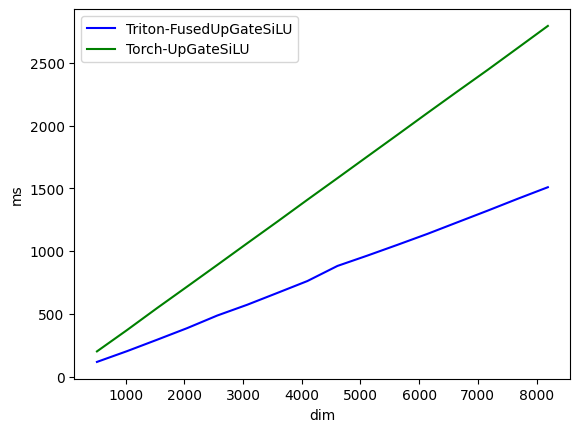

up gate silu backward:
       dim  Triton-FusedUpGateSiLU  Torch-UpGateSiLU
0    512.0              116.926856        200.794399
1   1024.0              202.678770        370.634466
2   1536.0              293.565422        545.732617
3   2048.0              386.010498        716.890097
4   2560.0              486.286521        888.922274
5   3072.0              572.418451       1062.282443
6   3584.0              666.370213       1234.196901
7   4096.0              761.181951       1408.577681
8   4608.0              881.501794       1580.769897
9   5120.0              964.240372       1754.045963
10  5632.0             1049.948692       1926.869988
11  6144.0             1137.457371       2100.938797
12  6656.0             1230.061650       2273.157120
13  7168.0             1322.284698       2443.655014
14  7680.0             1416.825056       2618.363380
15  8192.0             1508.612990       2793.484449


In [ ]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedUpGateSiLU', 'Torch-UpGateSiLU'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedUpGateSiLU",
            "Torch-UpGateSiLU",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="up gate silu backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 32}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    up = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
    up.requires_grad_(True)
    gate = torch.randn_like(up)
    gate.requires_grad_(True)
    dy = torch.ones_like(up)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'Triton-FusedUpGateSiLU':
        y = fused_up_gate_silu(up, gate)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[up, gate])
    if provider == 'Torch-UpGateSiLU':
        y = up_gate_silu(up, gate)
        ms = triton.testing.do_bench(lambda: y.backward(dy,retain_graph=True), grad_to_none=[up, gate])

    return ms * 1e3
print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# forward + backward

bs: 32, seq_len: 1024


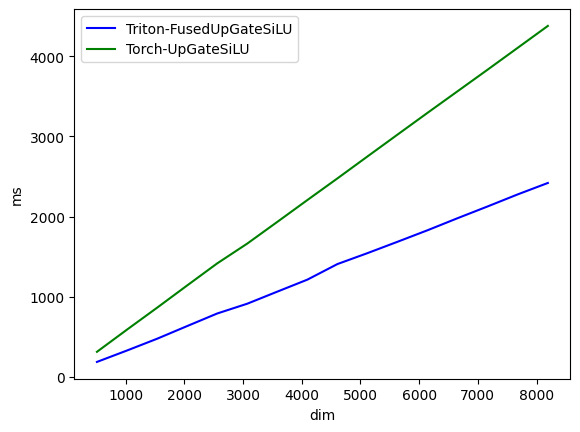

up gate silu forward + backward:
       dim  Triton-FusedUpGateSiLU  Torch-UpGateSiLU
0    512.0              187.339664        313.333631
1   1024.0              329.815477        590.434074
2   1536.0              476.323873        863.433540
3   2048.0              634.431541       1141.050220
4   2560.0              791.469097       1416.579008
5   3072.0              913.540542       1663.715363
6   3584.0             1064.322591       1934.445143
7   4096.0             1213.841081       2206.982851
8   4608.0             1408.272028       2477.096319
9   5120.0             1544.722319       2750.977278
10  5632.0             1686.546206       3023.798227
11  6144.0             1830.435634       3295.796871
12  6656.0             1981.032729       3565.246105
13  7168.0             2127.761841       3834.771395
14  7680.0             2277.846575       4107.024670
15  8192.0             2420.019865       4379.351139


In [62]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedUpGateSiLU', 'Torch-UpGateSiLU'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedUpGateSiLU",
            "Torch-UpGateSiLU",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="up gate silu forward + backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 32}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    up = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
    up.requires_grad_(True)
    gate = torch.randn_like(up)
    gate.requires_grad_(True)
    dy = torch.ones_like(up)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    def func(ops, gate, up, dy):
        y = ops(up, gate)
        y.backward(dy)

    if provider == 'Triton-FusedUpGateSiLU':
        ms = triton.testing.do_bench(lambda: func(fused_up_gate_silu, gate, up, dy), grad_to_none=[up, gate])
    if provider == 'Torch-UpGateSiLU':
        y = up_gate_silu(up, gate)
        ms = triton.testing.do_bench(lambda: func(up_gate_silu, gate, up, dy), grad_to_none=[up, gate])

    return ms * 1e3
print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)
